# 1. Install and import dependencies

In [ ]:
!pip install opencv-python --quiet
!pip install torchvision --quiet
!pip install torchsummary
!git init
# !git config --global --unset http.proxy 
# !git config --global --unset https.proxy
!git clone https://github.com/pytorch/vision.git

from google.colab import drive
drive.mount('/content/drive')

import os
import sys
import math
import time
import sklearn
import skimage
import cv2
import seaborn as sns; sns.set_theme()
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

Reinitialized existing Git repository in /content/.git/
fatal: destination path 'vision' already exists and is not an empty directory.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#2. Load Faster RCNN model and define bounding box functions

In [ ]:
# Smaller coco dataset to represent road objects
coco_small = {0:"Background", 1:"Person", 2:"Bicycle", 3:"Car", 
             4:"Motorcycle", 6:"Bus", 8:"Truck"}
coco_colors = {0:0, 1:1, 2:2, 3:3, 4:4, 6:5, 8:6}

# Load model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, min_size = 700)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
print("Model Summary:\n", model)
model.eval()

num_classes = len(coco_small) + 1
# box_colors = ['r', 'g', 'b', 'c', 'y', 'm', 'k', 'w']
box_colors = np.random.uniform(0, 255, (num_classes, 3))
transform = transforms.ToTensor()

""" 
Predict class and bounding box of objects in image

@parameter image_path: the image to analyze
@parameter nms_thresh: the threshold used in NMS
@parameter score_thresh: addition threshold for box scores
@return the bounding box coords, numerical labels, text labels, and box scores
"""
def predict(image, nms_thresh, score_thresh):
    image = transform(image).to(device)
    image = image.unsqueeze(0)
    with torch.no_grad():
        out = model.forward(image)
        # Apply nms to only keep desired boxes over threshold
        nms_keep = torchvision.ops.nms(out[0]['boxes'], out[0]['scores'], nms_thresh)
        out[0]['boxes'] = out[0]['boxes'][nms_keep]
        out[0]['scores'] = out[0]['scores'][nms_keep]
        out[0]['labels'] = out[0]['labels'][nms_keep]
        # Further remove via bbox score threshold
        score_keep = []
        for i, score in enumerate(out[0]['scores']):
            if score > score_thresh:
                score_keep.append(i)
        out[0]['boxes'] = out[0]['boxes'][score_keep]
        out[0]['scores'] = out[0]['scores'][score_keep]
        out[0]['labels'] = out[0]['labels'][score_keep]
        class_text = []
        # Convert numerical outputs to text
        for i in out[0]['labels'].cpu().numpy():
            if coco_small.get(i) is not None:
                class_text.append(coco_small.get(i))
            else:
                class_text.append("Other")
        out_labels = out[0]['labels'].detach().cpu().numpy()
        out_label_text = np.array(class_text)
        out_scores = out[0]['scores'].detach().cpu().numpy()
        out_bboxes = out[0]['boxes'].detach().cpu().numpy()
    return out_bboxes, out_labels, out_label_text, out_scores

""" 
Draw the bounding boxes on the image 

@parameter boxes: the bounding box coordinates
@parameter labels: the numerical object labels
@parameter labels_text: the textural object labels (classes)
@paramaeter image_path: the path to the image
@parameter save_path: the image to analyze
@return the new image with bounding boxes
"""
def drawBox(boxes, labels, labels_text, image, save_path):
    # image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    label_adjust = []
    # Convert labels to smaller coco labels defined above
    for label in labels:
        new_label = (coco_colors.get(label) if coco_colors.get(label) is not None 
                     else len(coco_small))
        label_adjust.append(new_label)
    for i, box in enumerate(boxes):
        color = box_colors[label_adjust[i]]
        cv2.rectangle(image, (int(box[0]), int(box[1])), 
                      (int(box[2]), int(box[3])), color, 2)
        cv2.putText(image, labels_text[i], (int(box[0]), int(box[1]-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2, 
                    lineType = cv2.LINE_AA)
    return image

Model Summary:
 FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(700,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
       

#3. Load sample image from MIO-TCD dataset and COCO dataset

In [ ]:
"""
Conduct object detection on the image

@parameter image_path: the path to the image
@parameter save_path: the path to save the image under
"""
def image_write(image_path, save_path):
    image = cv2.imread(image_path)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    boxes, labels, classes, scores = predict(image, 0.3, 0.7)
    image = drawBox(boxes, labels, classes, image, image_save_path)
    cv2.imwrite(save_path, image)
    print("Raw labels and scores:", labels, scores)

# Sample images from MIO-TCD dataset
image_write("/content/drive/My Drive/Cavnue/car.jpg", 
            "/content/drive/My Drive/Cavnue/car_box.jpg")
image = cv2.imread("/content/drive/My Drive/Cavnue/car.jpg")
image_write("/content/drive/My Drive/Cavnue/car_2.jpg", 
            "/content/drive/My Drive/Cavnue/car_2_box.jpg")
image_write("/content/drive/My Drive/Cavnue/bus.jpg", 
            "/content/drive/My Drive/Cavnue/bus_box.jpg")

# Sample images from COCO 2017 validation set
image_write("/content/drive/My Drive/Cavnue/coco_cars.jpg", 
            "/content/drive/My Drive/Cavnue/coco_cars_box.jpg")
image_write("/content/drive/My Drive/Cavnue/coco_motorcycle.jpg", 
            "/content/drive/My Drive/Cavnue/coco_motorcycle_box.jpg")
image_write("/content/drive/My Drive/Cavnue/coco_truck.jpg", 
            "/content/drive/My Drive/Cavnue/coco_truck_box.jpg")

Raw labels and scores: [3] [0.8895517]
Raw labels and scores: [3] [0.84804547]
Raw labels and scores: [ 3 62  7  1] [0.9693182  0.8489591  0.82901263 0.7005915 ]
Raw labels and scores: [ 3 28  3  3  3  3  3] [0.9738801  0.93698776 0.8863592  0.88238174 0.8472619  0.78413975
 0.7839913 ]
Raw labels and scores: [ 1  1  1  6 10  6] [0.99765116 0.9882881  0.9873581  0.92731047 0.8131401  0.7784608 ]
Raw labels and scores: [ 8  8 15  8] [0.9899741  0.881773   0.83350396 0.7551921 ]


#4. Load sample traffic video and run object detection

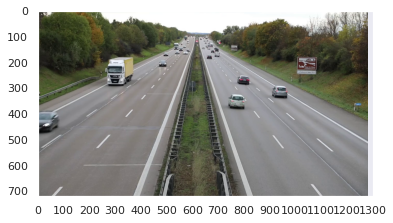

In [ ]:
# Display single video frame
video_path = "/content/drive/My Drive/Cavnue/traffic_3.mp4"
video = cv2.VideoCapture(video_path)
ret, frame = video.read()
video.release()
plt.imshow(frame[:,:,::-1])
# plt.plot(200, 350, 'bo')
# plt.plot(325, 350, 'bo')
# plt.plot(460, 350, 'bo')
plt.show
plt.xticks(np.arange(0, 1400, step = 100))
plt.grid(False)

In [ ]:
"""
Find the centroid of the bounding box

@parameter box: the bounding box
@return the box centroid
"""
def center_coord(box):
    minX = box[0]
    minY = box[1]
    maxX = box[2]
    maxY = box[3]
    return ((maxX - minX), (maxY - minY))
    
"""
Isolate video frames and conduct object detection. Count the number of objects
in each lane by class

@parameter video_path: the path to the video
@parameter video_save_path: the path to save the video under
"""
def video_detect(video_path, video_save_path):
    # Open video
    video = cv2.VideoCapture(video_path)
    frame_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_fps = int(video.get(cv2.CAP_PROP_FPS))
    writer = cv2.VideoWriter(video_save_path, cv2.VideoWriter_fourcc(*'mp4v'), 
                             frame_fps, (frame_width, frame_height))
    frame_count = 0
    total_fps = 0

    # Read each video frame and conduct analysis
    while True:
        ret, frame = video.read()
        if not ret:
            break
        start = time.time()
        boxes, labels, classes, scores  = predict(frame, 0.3, 0.7)
        image = drawBox(boxes, labels, classes, frame, video_save_path)
        end = time.time()
        fps = (1/(end - start))
        total_fps += fps
        frame_count += 1
        writer.write(image)
    video.release()
    return (total_fps/frame_count)
            

fps = video_detect(video_path, 
                    "/content/drive/My Drive/Cavnue/traffic_3_box.mp4")
print("Average FPS: {}".format(fps))

Average FPS: 8.023728066697796
